In [2]:
import datetime as dt  
import pandas as pd
import numpy as np
from netCDF4 import Dataset 
import copy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from ncdump import ncdump
import gdal
import pytz
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
from VPRM_params import NLCD_def, bbox
from VPRMout_fun import Read_VPRMout,latlon_to_EPSG32618,find_a_point_in_grids,get_first_dimension_ave,EPSG32618_to_latlon

def et_to_utc(dt_et):
    utc = pytz.timezone('UTC')
    est = pytz.timezone('US/Eastern')   
    outputfmt  = '%Y-%m-%d %H:%M:%S'
    dt_utc = est.localize(dt_et).astimezone(utc) #.strftime(outputfmt)
    return dt_utc

timezone = pytz.timezone("UTC")

# NLCD data
DataDir = '/data0/dwei/VPRMdata/'   # input dir
ds_nlcd = gdal.Open(DataDir+'nlcd_epsg32618_cropped.tif')
NLCD_2D = ds_nlcd.GetRasterBand(1).ReadAsArray()

Datadir = '/data0/dwei/VPRMout/'
file1 = 'DBF_2021-0415_20220315.nc' # before April 15 for DEV as forest
file2 = 'DBF_2021_0415_20220309.nc' # after April 15 for DEV as forest
file_grs = 'DEVasGRS_2021_apr_oct_20220331.nc'


In [2]:
# Regrid the DEV-as-DBF case 
# Read the file from April 15 8:00 to July 31 23:00
nc_fid = Dataset(Datadir+file2, 'r')  
Xdim  = nc_fid.variables['Xdim'][:] 
Ydim  = nc_fid.variables['Ydim'][:] 
time  = nc_fid.variables['time'][:]
dt_et = np.array([dt.datetime.fromtimestamp(t) for t in time])
dt_utc= np.array([et_to_utc(t) for t in dt_et])

# Determine the index
ts_tgt_naive = dt.datetime(2021, 11, 1, 0, 0, 0) # 11-1 00:00 in UTC
ts_tgt = timezone.localize(ts_tgt_naive)
ind_tgt = np.where(dt_utc == ts_tgt)
print(ind_tgt)
Time = dt_utc[0:ind_tgt[0][0]] # UTC
GEE   = nc_fid.variables['GEE'][0:ind_tgt[0][0],:,:]  # GEE   [mol m^-2 hr^-1']
Res_H = nc_fid.variables['RESH'][0:ind_tgt[0][0],:,:] # Res_H [mol m^-2 hr^-1']
Res_A = nc_fid.variables['RESA'][0:ind_tgt[0][0],:,:] # Res_A [mol m^-2 hr^-1']
TMP = Res_A+Res_H
del Res_A, Res_H
NEE = TMP+GEE
print(np.shape(NEE))
nc_fid.close()

# Read the file from April 1 00:00 to April 15 23:00
nc_fid = Dataset(Datadir+file1, 'r')  
time  = nc_fid.variables['time'][:]
dt_et1 = np.array([dt.datetime.fromtimestamp(t) for t in time])
dt_utc1= np.array([et_to_utc(t) for t in dt_et1])
# Find the index
ind_tgt = np.where(dt_utc1 == Time[0])
print(ind_tgt)
theind = ind_tgt[0][0] # not including ind_tgt
Time1 = dt_utc1[0:theind]
GEE1   = nc_fid.variables['GEE'][0:theind,:,:]  # GEE   [mol m^-2 hr^-1']
Res_H1 = nc_fid.variables['RESH'][0:theind,:,:] # Res_H [mol m^-2 hr^-1']
Res_A1 = nc_fid.variables['RESA'][0:theind,:,:] # Res_A [mol m^-2 hr^-1']
Res1 = Res_H1+Res_A1
del Res_H1, Res_A1
NEE1   = GEE1+Res1
nc_fid.close()

# Fix the missing data by adding NaNs
Time_gap_naive = np.array([dt.datetime(2021, 4, 1, 0, 0, 0,pytz.UTC)+dt.timedelta(hours=h) for h in range(0,4)])
Time_gap = np.array([timezone.localize(d) for d in Time_gap_naive])
NEE_gap = np.empty((4, np.size(Ydim), np.size(Xdim))) # four-hour data are missing
GEE_gap = np.empty((4, np.size(Ydim), np.size(Xdim))) # four-hour data are missing
Res_gap = np.empty((4, np.size(Ydim), np.size(Xdim))) # four-hour data are missing
NEE_gap[:,:,:] = np.nan
GEE_gap[:,:,:] = np.nan
Res_gap[:,:,:] = np.nan
print(Time_gap)

# Merge the three components to get GEE, NEE, Res for April-October
Time_all = np.concatenate((Time_gap, Time1, Time), axis=0)
Time_all_str = np.array([dd.strftime("%Y-%m-%d %H:%M") for dd in Time_all])
NEE_all = np.vstack((NEE_gap, NEE1, NEE))
del NEE1, NEE, NEE_gap
GEE_all = np.vstack((GEE_gap, GEE1, GEE))
del GEE_gap, GEE1, GEE
Res_all = np.vstack((Res_gap, Res1, TMP))
del Res_gap, Res1, TMP

# NLCD has zeros in the southeast corner
GEE_all[:,NLCD_2D==0]=0.0  
Res_all[:,NLCD_2D==0]=0.0  
NEE_all[:,NLCD_2D==0]=0.0  
# set water to zeros for re-gridding
NEE_all[:,NLCD_2D==11]=0.0 
GEE_all[:,NLCD_2D==11]=0.0 
Res_all[:,NLCD_2D==11]=0.0 

# # Check missing data (NaNs)
# NaN_num = []
# for ind in range(0,2928):
#     NEE_tmp=NEE_all[ind, :, :].reshape(1560*1546)
#     NaN_num.append(np.size(NEE_tmp[np.isnan(NEE_tmp)]))
# NaN_num = np.array(NaN_num)

# import matplotlib.dates as mdates
# from matplotlib.dates import DateFormatter
# fig,ax=plt.subplots(1, figsize=(8,5))
# ax.plot(DT_all, NaN_num/land_pix_num*100.0, marker='.', linestyle='')
# ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
# ax.xaxis.set_major_formatter(DateFormatter("%m-%d"))
# ax.set_ylabel('% of NaNs (water excluded)')
# ax.set_xlabel('Date')
# ax.set_ylim(0, 100)


(array([4788]),)


MemoryError: Unable to allocate 86.0 GiB for an array with shape (4788, 1560, 1546) and data type float64

In [ ]:
# Regrid the DEV-as-grass case 
# Read the file_grs 
start_time = dt.datetime.now()
print('======================================================')

nc_fid = Dataset(Datadir+file_grs, 'r')  
Xdim  = nc_fid.variables['Xdim'][:] 
Ydim  = nc_fid.variables['Ydim'][:] 
time  = nc_fid.variables['time'][:]
dt_et = np.array([dt.datetime.fromtimestamp(t) for t in time])
Time_all= np.array([et_to_utc(t) for t in dt_et])

Res_H = nc_fid.variables['RESH'][:,:,:] # Res_H [mol m^-2 hr^-1']
Res_A = nc_fid.variables['RESA'][:,:,:] # Res_A [mol m^-2 hr^-1']
Res_all = Res_H+Res_A
del Res_H, Res_A
GEE_all = nc_fid.variables['GEE'][:,:,:] # GEE [mol m^-2 hr^-1']
NEE_all = GEE_all+Res_all
nc_fid.close()

print('time dimension : %f' %np.shape(time))
print('NEE dimension : ', (np.shape(NEE_all)))
print('GEE dimension : ', (np.shape(GEE_all)))
print('Res dimension : ', (np.shape(Res_all)))
print('Lat and Lon dimensions : ', np.shape(Ydim), np.shape(Xdim))

# NLCD has zeros in the southeast corner
GEE_all[:,NLCD_2D==0]=0.0  
Res_all[:,NLCD_2D==0]=0.0  
NEE_all[:,NLCD_2D==0]=0.0  
# set water to zeros for re-gridding
NEE_all[:,NLCD_2D==11]=0.0 
GEE_all[:,NLCD_2D==11]=0.0 
Res_all[:,NLCD_2D==11]=0.0 

time_dela = dt.datetime.now()-start_time       
print("================ Finished in %f mins ============" %(time_dela.total_seconds()/60))

# Check missing data (NaNs)
NaN_num = []
for ind in range(0,np.size(NEE_all[:,0,0])):
    NEE_tmp=NEE_all[ind, :, :].reshape(1560*1546)
    NaN_num.append(np.size(NEE_tmp[np.isnan(NEE_tmp)]))
NaN_num = np.array(NaN_num)

plt.figure()
plt.plot(range(0,np.size(NEE_all[:,0,0])), np.array(NaN_num)/2411760*100)

In [9]:
# Regrid information
# 0.01deg x 0.01deg grid where the gridbox edges are 0.01, 0.02, 0.03, etc, 
# Specifically, the domain is -75 to -72.5 lon x 40 to 42 lat, or 250 x 200 boxes. 
# I think your VPRM will be only the middle of this domain
Lons = np.arange(-75.0, -72.5, 0.01) # column number
Lats = np.arange(42.0, 40.0, -0.01)  # row number
Lon, Lat = np.meshgrid(Lons, Lats)
print(np.shape(Lons))
print(np.shape(Lons))
Lat_1D = Lat.reshape(np.size(Lat)) 
Lon_1D = Lon.reshape(np.size(Lat))

# Read the center lat lon for the NYC-domain
df=pd.read_csv('/data0/dwei/VPRMout/NYC_domain_center_latlon')
#print(df.head())
center_lat = df.to_numpy()[:,1]
center_lon = df.to_numpy()[:,2]


(250,)
(250,)


In [10]:
# Outputs
OutDir  = '/data0/dwei/VPRMout/'   # Output dir
Domname = 'DEVasGRS_VPRM_apr_oct'

try: ncfile.close()  # just to be safe, make sure dataset is not already open.
except: pass

str_today = dt.datetime.strftime(dt.date.today(), '%Y%m%d') # string type
outfile = OutDir+Domname+'_'+str_today+'.nc'

# Opening a file, creating a new Dataset
ncfile = Dataset(outfile,mode='w',format='NETCDF4') 

# Creating dimensions
lon_dim = ncfile.createDimension('lon', 250)      # cols, equivalent to lon 
lat_dim = ncfile.createDimension('lat', 200)      # rows, equivalent to lat
time_dim = ncfile.createDimension('time', None) # unlimited axis (can be appended to).
#for dim in ncfile.dimensions.items():
#   print(dim)

# Creating attributes
#ncfile.title='NYC domain 2021'
#print(ncfile.title)

# Creating variables
# Define two variables with the same names as dimensions,
# a conventional way to define "coordinate variables".
lon = ncfile.createVariable('lon', np.float32, ('lon',))
lon.units = 'degree'
lon.long_name = 'Longitude'

lat = ncfile.createVariable('lat', np.float32, ('lat',))
lat.units = 'degree'
lat.long_name = 'Latitude'

time = ncfile.createVariable('time', np.float64, ('time',))
time.units = 'seconds since 00:00:00 UTC on 1 January 1970'
time.long_name = 'seconds since 00:00:00 UTC on 1 January 1970'
#print(time)

# Define a 3D variable to hold the data
NEE = ncfile.createVariable('NEE',np.float64,('time','lat','lon')) 
NEE.units = '\u03BCmoles m-2 s-1'
NEE.standard_name = 'Net Ecosystem Exchange'

GEE = ncfile.createVariable('GEE',np.float64,('time','lat','lon')) 
GEE.units = '\u03BCmoles m-2 s-1'
GEE.standard_name = 'Gross Ecosystem Exchange'

Res = ncfile.createVariable('Res',np.float64,('time','lat','lon')) 
Res.units = '\u03BCmoles m-2 s-1'
Res.standard_name = 'Gross Ecosystem Exchange'

# Writing the coordinates
lon[:] = Lons+0.01/2   # east-west   
lat[:] = Lats-0.01/2   # north-south 
# ncfile= create_vprm_output('test3', np.shape(NLCD_2D)[1], np.shape(NLCD_2D)[0], X_cord[0,:], Y_cord[:,0])   
# print(ncfile)
print('------------- %s file created --------------' %outfile)



------------- /data0/dwei/VPRMout/DEVasGRS_VPRM_apr_oct_20220404.nc file created --------------


In [ ]:
# Loop through each pixel (from left to right and then top to bottom) using lat&lons
big_res = 0.01
row = np.shape(Lat)[0]
col = np.shape(Lat)[1]
print('The new grid shape : %d, %d' %(row,col))

start_time = dt.datetime.now()
print('======================================================')

NEE_tmp = np.empty((len(Time_all), row*col)) # four-hour data are missing
NEE_tmp[:,:] = np.nan
GEE_tmp = np.empty((len(Time_all), row*col)) # four-hour data are missing
GEE_tmp[:,:] = np.nan
Res_tmp = np.empty((len(Time_all), row*col)) # four-hour data are missing
Res_tmp[:,:] = np.nan
ind_px = 0
for lat,lon in zip(Lat_1D, Lon_1D): # Each pixel (50000 in total)
    if np.mod(ind_px,5000)==1.0:
        print(ind_px, lat,lon)

    if lat>40.92 or lat<40.49 or lon<-74.26 or lon>-73.70:
        ind_px+=1
        continue

    b1 = np.logical_and(center_lat>=lat-big_res, center_lat<lat) 
    b2 = np.logical_and(center_lon>=lon, center_lon<lon+big_res) 
    boo = np.logical_and(b1,b2) 
    boo_2D = np.array(boo).reshape(np.shape(NEE_all[0,:,:])) 

    NEE_tmp[:, ind_px] = np.nanmean(NEE_all[:, boo_2D], axis=1)
    GEE_tmp[:, ind_px] = np.nanmean(GEE_all[:, boo_2D], axis=1)
    Res_tmp[:, ind_px] = np.nanmean(Res_all[:, boo_2D], axis=1)
    ind_px+=1
    
time_dela = dt.datetime.now()-start_time       
print("================ Finished in %f mins ============" %(time_dela.total_seconds()/60))

# Save the data to the netCDF file
print(np.shape(NEE_tmp))
print(np.shape(GEE_tmp))
print(np.shape(Res_tmp))
Timestamp = np.array([dt.datetime.timestamp(t) for t in Time_all])
print('The first timestamp is %s' %dt.datetime.fromtimestamp(Timestamp[0]))
ind=0
for t in Timestamp:
    time[ind]=t
    NEE[ind, :, :] = NEE_tmp[ind].reshape(200,250)
#     GEE[ind, :, :] = GEE_tmp[ind].reshape(200,250)
#     Res[ind, :, :] = Res_tmp[ind].reshape(200,250)
    ind+=1
ncfile.close()


NEE dimension :  (5136, 200, 250)
GEE dimension :  (5136, 200, 250)
Res dimension :  (5136, 200, 250)
time dimension : 5136.000000
Lon and Lat dimensions :  (250,) (200,)
682.0799999999999
(5136,)


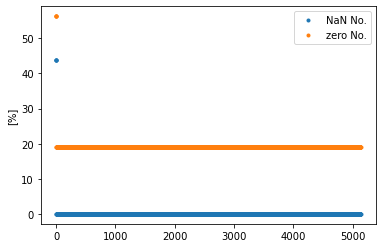

In [3]:
# Check the nclfile 
file_DEVasGRS = 'DEVasGRS_VPRM_apr_oct_20220401.nc'
file_DEVasDBF = 'VPRM_apr_oct_20220331.nc'
filepath='/data0/dwei/VPRMout/'+file_DEVasDBF
nc_fid = Dataset(filepath, 'r')  
#nc_attrs, nc_dims, nc_vars = ncdump(nc_fid)
NEE    = nc_fid.variables['NEE'][:,:,:] 
GEE    = nc_fid.variables['GEE'][:,:,:]
Res    = nc_fid.variables['Res'][:,:,:]
time   = nc_fid.variables['time'][:]
lons   = nc_fid.variables['lon'][:] 
lats   = nc_fid.variables['lat'][:] 
nc_fid.close()
print('NEE dimension : ', (np.shape(NEE)))
print('GEE dimension : ', (np.shape(GEE)))
print('Res dimension : ', (np.shape(Res)))
print('time dimension : %f' %np.shape(time))
print('Lon and Lat dimensions : ', np.shape(lons),np.shape(lats))

# Calculate the number of NaNs and zeros for each hour
zero_num = []
NaN_num = []
for ind in range(0, 5136):
    NEE_tst=NEE[ind, :, :].reshape(200*250)
    NaN_num.append(len(NEE_tst[np.isnan(NEE_tst)]))
    zero_num.append(len(NEE_tst[NEE_tst==0.0]))

NaN_num = np.array(NaN_num)
zero_num = np.array(zero_num)
expected_NaNs=47648
expected_zeros=42*56*0.29
print(expected_zeros)
print(np.shape(zero_num))

plt.figure()
plt.plot(range(0,5136), (NaN_num-expected_NaNs)/(50000-expected_NaNs)*100.0, label='NaN No.',
         marker='.', linestyle='')
plt.plot(range(0,5136), zero_num/(42*56)*100.0, label='zero No.',
         marker='.', linestyle='')   # water coverage in the small domain
plt.ylabel('[%]')
plt.legend()



/opt/sw/anaconda3/envs/GDAL+/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


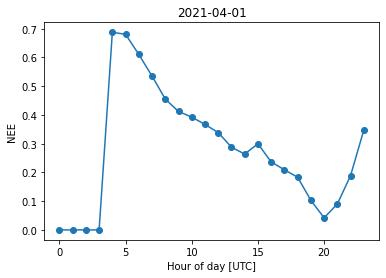

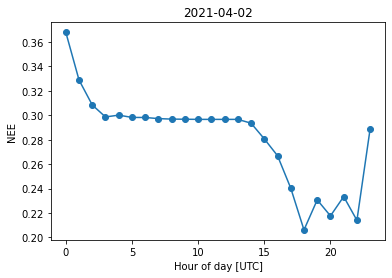

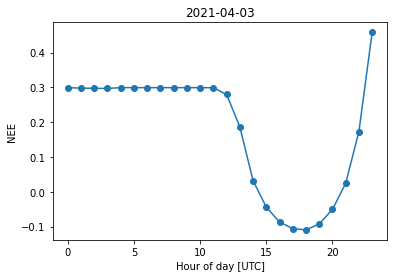

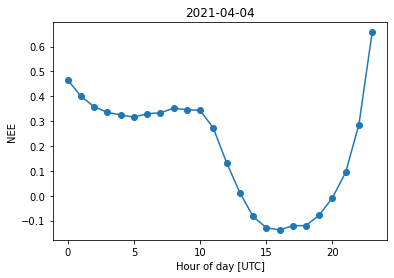

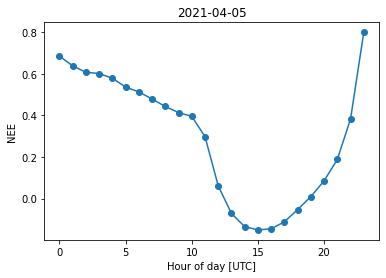

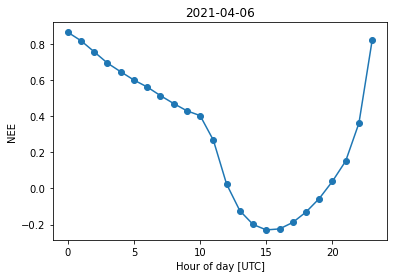

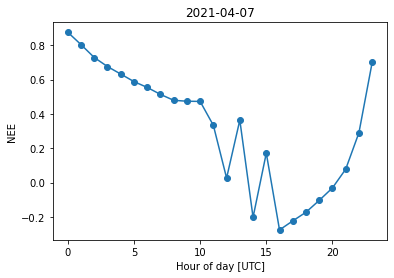

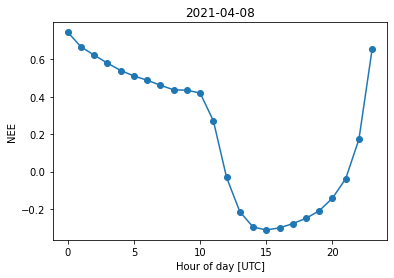

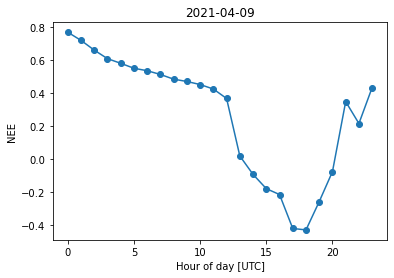

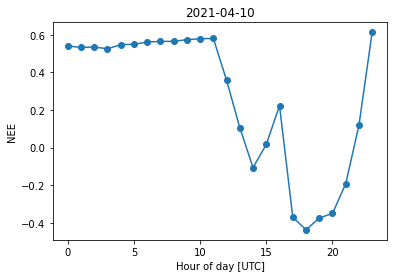

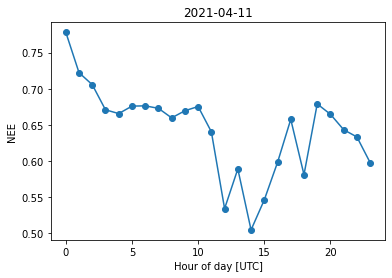

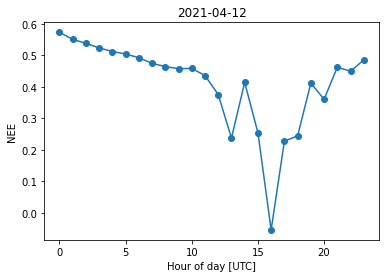

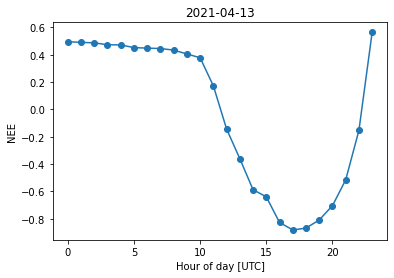

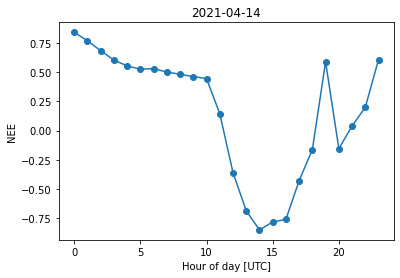

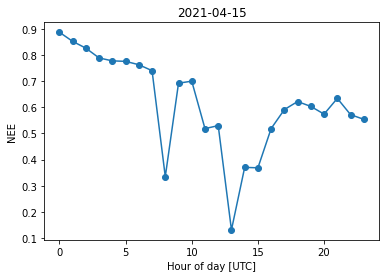

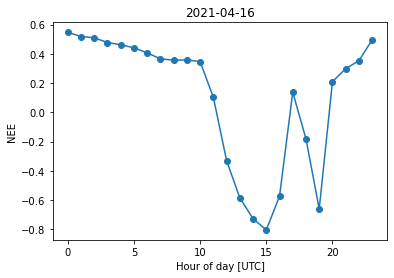

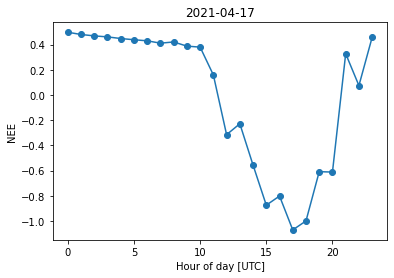

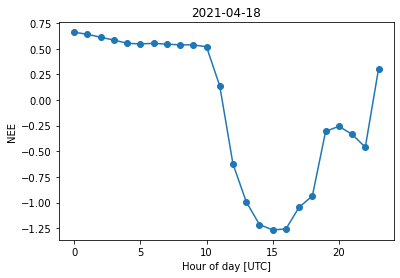

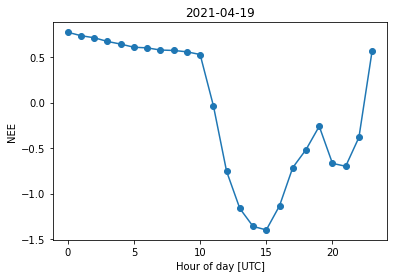

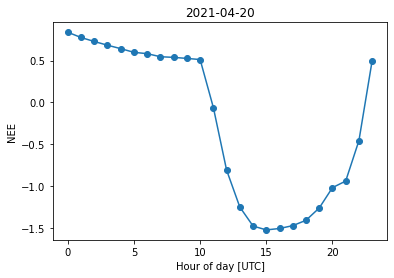

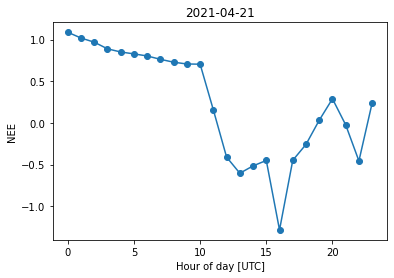

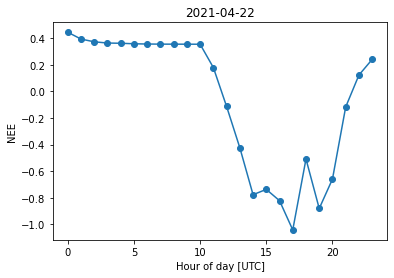

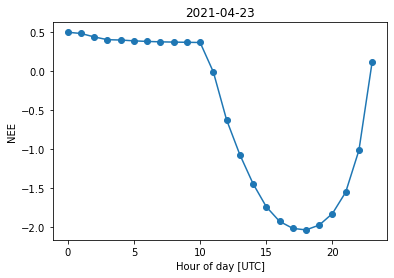

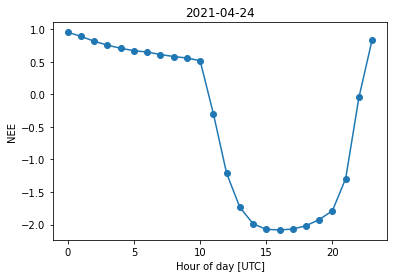

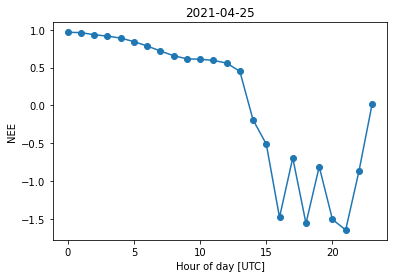

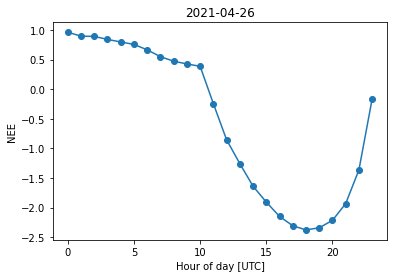

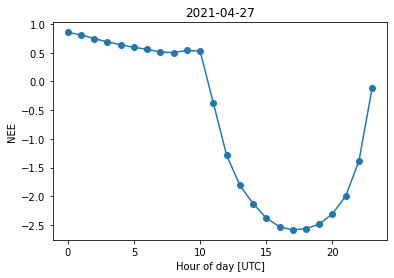

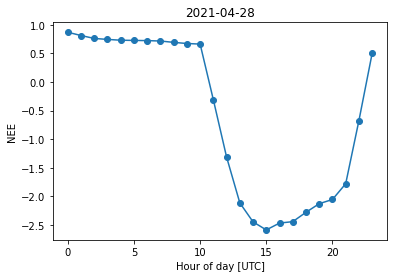

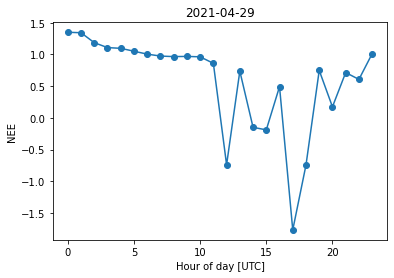

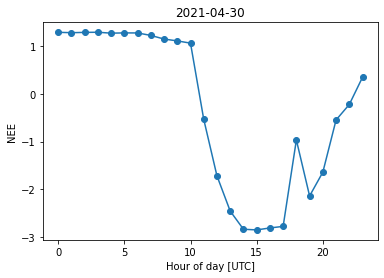

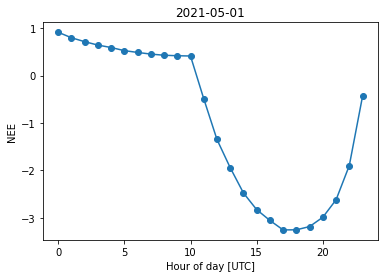

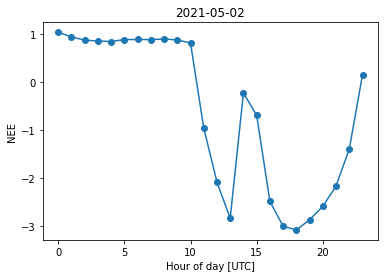

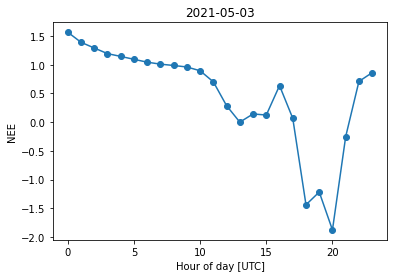

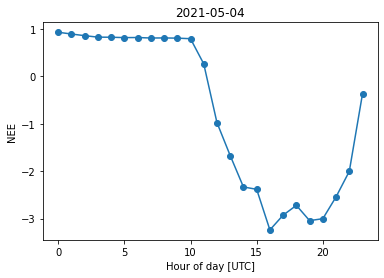

Error in callback <function flush_figures at 0x7fcf9049c3b0> (for post_execute):


KeyboardInterrupt: 

In [79]:
# Plot the daily domain averages
DT = np.array([dt.datetime.fromtimestamp(t) for t in time])
DTDates = np.array([t.date() for t in DT])
for day in [dt.date(2021,4,1)+dt.timedelta(days=x) for x in range(0,214)]:
    plt.figure()
    plt.title(day)
    boo=DTDates==day
    NEE_tst=NEE[boo, :, :]
    NEE_tst1=np.array([np.nanmean(NEE_tst[i, :, :]) for i in range(0,24)])
    plt.plot(np.array([t.hour for t in DT[boo] ]), NEE_tst1, marker='o')
    plt.xlabel('Hour of day [UTC]')
    plt.ylabel('NEE')
    

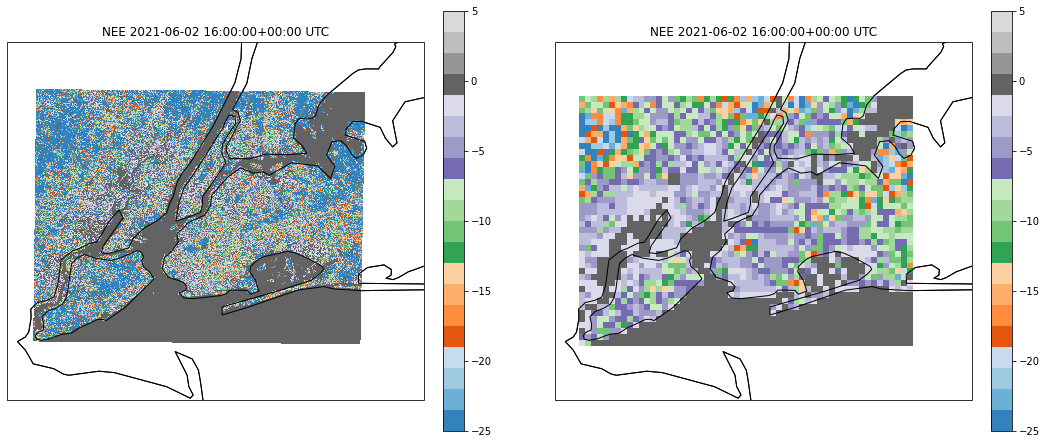

In [88]:
# Plot the image for a specific hour
dt_tgt_naive = dt.datetime(2021, 6, 2, 16, 0)
dt_tgt = timezone.localize(dt_tgt_naive)
NEE_nyc = NEE_all[Time_all==dt_tgt,:,:].reshape(1560,1546)
GEE_nyc = GEE_all[Time_all==dt_tgt,:,:].reshape(1560,1546)
Res_nyc = Res_all[Time_all==dt_tgt,:,:].reshape(1560,1546)

# set up a map
fig = plt.figure(figsize=(18,8)) #plt.subplots(2, 2, figsize=(15,6))
row = 1
col=2
extent = [-74.3, -73.6, 40.4, 41]
Vmin = -25
Vmax = 5
Cmap = 'tab20c'

# 30-res NYC-VPRM on a map
ax = fig.add_subplot(row, col, 1, projection=ccrs.PlateCarree())
ax.set_title('NEE %s UTC' %dt_tgt)
ax.coastlines(resolution='10m')
ax.set_extent(extent)
cc = ax.pcolormesh(center_lon.reshape(1560, 1546), center_lat.reshape(1560, 1546),NEE_nyc, 
               transform=ccrs.PlateCarree(),vmin=Vmin, vmax = Vmax, cmap=Cmap)
cbar = plt.colorbar(cc, ax=ax,fraction=0.046, pad=0.04)
ax.coastlines()

# 0.01 degree res
ax = fig.add_subplot(row, col, 2, projection=ccrs.PlateCarree())
#ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title('NEE %s UTC' %dt_tgt)
ax.coastlines(resolution='10m')
ax.set_extent(extent)

cc = ax.pcolormesh(lons, lats, NEE[time==dt.datetime.timestamp(dt_tgt),:,:].reshape(200,250), 
                    transform=ccrs.PlateCarree(),vmin =Vmin, vmax = Vmax, cmap=Cmap)
cbar = plt.colorbar(cc, ax=ax,fraction=0.046, pad=0.04)
ax.coastlines()
plt.show()


(5136,) (5136,)


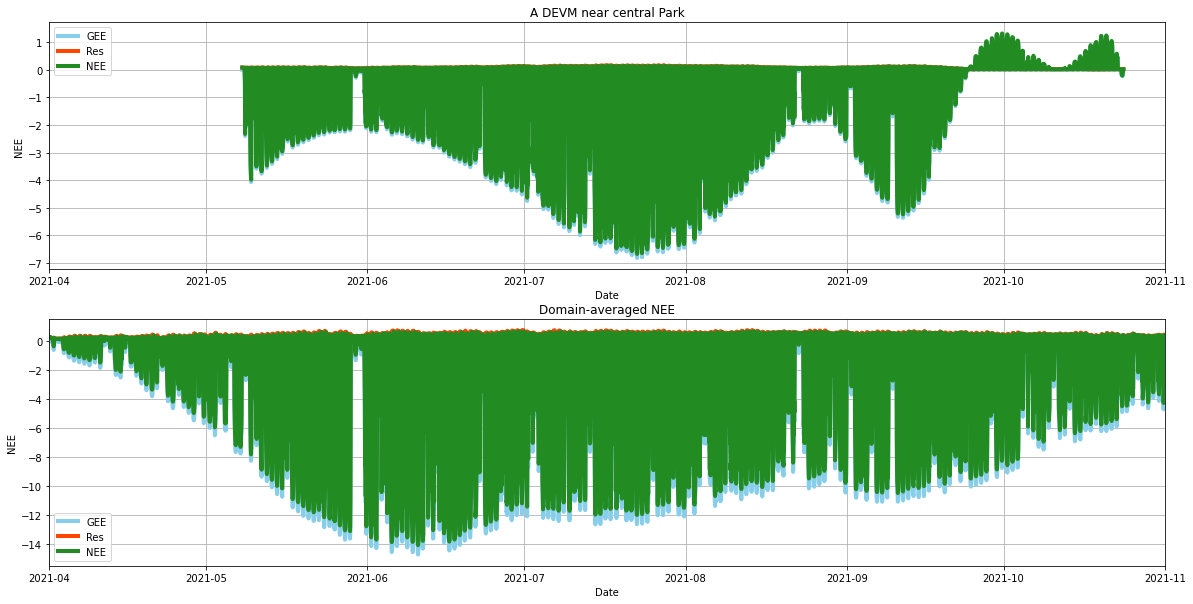

In [89]:
# Time series of a specific location and domain averages
CTPK = [40.772351, -73.974423]                  # A DEVM (23) near Central park
WLCT = (40.89050576788395, -73.87268730819294)  # Woodlawn cemetary
x,y = latlon_to_EPSG32618(WLCT) 
x_ind,y_ind = find_a_point_in_grids(x, y, Xdim, Ydim)
NEE_loc = NEE_all[:, x_ind, y_ind].flatten()
GEE_loc = GEE_all[:, x_ind, y_ind].flatten()
Res_loc = Res_all[:, x_ind, y_ind].flatten()

# Time series of domain averages
Dom_ave_NEE = np.array([np.nanmean(NEE_all[x, :, :]) for x in range(0, len(Time_all))])
Dom_ave_GEE = np.array([np.nanmean(GEE_all[x, :, :]) for x in range(0, len(Time_all))])
Dom_ave_Res = np.array([np.nanmean(Res_all[x, :, :]) for x in range(0, len(Time_all))])

print(np.shape(NEE_loc),np.shape(Dom_ave_NEE))

# The time period interested
DT_dates = np.array([t.date() for t in Time_all])
DT_month = np.array([t.month for t in Time_all])

fig = plt.figure(figsize=(20,10))
FontSize = 10
LineWidth =4
row = 2
col = 1

ax = fig.add_subplot(row, col, 1)
ax.set_title('A DEVM near central Park')
ax.plot(Time_all, GEE_loc, color='skyblue', linewidth=LineWidth, label='GEE')
ax.plot(Time_all, Res_loc, color='orangered', linewidth=LineWidth, label='Res')
ax.plot(Time_all, NEE_loc, color='forestgreen', linewidth=LineWidth, label='NEE')
# ax.set_xticks(range(0, 24, 4))
ax.set_ylabel('NEE', fontsize = FontSize)
ax.set_xlabel('Date', fontsize = FontSize)
ax.grid()
ax.set_xlim(dt.date(2021, 4, 1), dt.date(2021, 11, 1))
ax.legend()

ax = fig.add_subplot(row, col, 2)
ax.set_title('Domain-averaged NEE')
ax.plot(Time_all, Dom_ave_GEE, color='skyblue', linewidth=LineWidth, label='GEE')
ax.plot(Time_all, Dom_ave_Res, color='orangered', linewidth=LineWidth, label='Res')
ax.plot(Time_all, Dom_ave_NEE, color='forestgreen', linewidth=LineWidth, label='NEE')
# ax.set_xticks(range(0, 24, 4))
ax.set_ylabel('NEE', fontsize = FontSize)
ax.set_xlabel('Date', fontsize = FontSize)
ax.set_xlim(dt.date(2021, 4, 1), dt.date(2021, 11, 1))
ax.grid()
ax.legend()


In [1]:
# Total fluxes sanity check
# NEE_all : VPRM
# NEE     : regridded
print('30-m        : ', np.shape(NEE_all))
print('0.01 degree : ', np.shape(NEE))

# The area between two lines of latitude is: 
# A = 2*pi*R^2 |sin(lat1) - sin(lat2)| where R is the radius of the earth
# The area of a lat-long rectangle is proportional to the difference in the longitudes:
# A = 2*pi*R^2 |sin(lat1)-sin(lat2)| |lon1-lon2|/360= (pi/180)R^2 |sin(lat1)-sin(lat2)| |lon1-lon2|
# Equatorial radius (km) :   6378.137 
# Polar radius (km)      : 6356.752 
R = (6378137.0+6356752.0)/2.0
lrg_res = 0.01
lrg_area = []
for lat in Lat_1D:
    lat1_rad = np.radians(lat)
    lat2_rad = np.radians(lat-lrg_res)
    lon_rad = np.radians(lat-lrg_res/2)
    ss = (np.pi/180.0)*R**2*(np.sin(lat1_rad)-np.sin(lat2_rad))*lrg_res
    lrg_area.append(ss)
lrg_area = np.array(lrg_area)
sml_area = 30.0*30.0

# Hourly rates
ind=0
sml_per_hr=[]
lrg_per_hr=[]
sml_per_hr_gee=[]
lrg_per_hr_gee=[]
sml_per_hr_res=[]
lrg_per_hr_res=[]
for t in Time_all:
    # NEE
    sml_per_hr.append(np.nansum(NEE_all[ind,:,:].reshape(np.size(NEE_all[ind,:,:])))*sml_area)
    lrg_per_hr.append(np.nansum(np.multiply(NEE[ind,:,:].reshape(np.size(NEE[ind,:,:])), lrg_area)))
    # GEE
    sml_per_hr_gee.append(np.nansum(GEE_all[ind,:,:].reshape(np.size(GEE_all[ind,:,:])))*sml_area)
    lrg_per_hr_gee.append(np.nansum(np.multiply(GEE[ind,:,:].reshape(np.size(GEE[ind,:,:])), lrg_area)))
    # Res
    sml_per_hr_res.append(np.nansum(Res_all[ind,:,:].reshape(np.size(Res_all[ind,:,:])))*sml_area)
    lrg_per_hr_res.append(np.nansum(np.multiply(Res[ind,:,:].reshape(np.size(Res[ind,:,:])), lrg_area)))
    ind+=1
lrg_per_hr = np.array(lrg_per_hr)
sml_per_hr = np.array(sml_per_hr)
lrg_per_hr_gee = np.array(lrg_per_hr_gee)
sml_per_hr_gee = np.array(sml_per_hr_gee)
lrg_per_hr_res = np.array(lrg_per_hr_res)
sml_per_hr_res = np.array(sml_per_hr_res)

# Daily rates
sml_per_mon = []
lrg_per_mon = []
sml_per_mon_gee = []
lrg_per_mon_gee = []
sml_per_mon_res = []
lrg_per_mon_res = []
for month in range(4, 11):
    # NEE
    sml_per_mon.append(np.nansum(sml_per_hr[DT_month==month])*3600.0)
    lrg_per_mon.append(np.nansum(lrg_per_hr[DT_month==month])*3600.0)
    # GEE
    sml_per_mon_gee.append(np.nansum(sml_per_hr_gee[DT_month==month])*3600.0)
    lrg_per_mon_gee.append(np.nansum(lrg_per_hr_gee[DT_month==month])*3600.0)
    # Res
    sml_per_mon_res.append(np.nansum(sml_per_hr_res[DT_month==month])*3600.0)
    lrg_per_mon_res.append(np.nansum(lrg_per_hr_res[DT_month==month])*3600.0)
lrg_per_mon = np.array(lrg_per_mon)
sml_per_mon = np.array(sml_per_mon)
lrg_per_mon_gee = np.array(lrg_per_mon_gee)
sml_per_mon_gee = np.array(sml_per_mon_gee)
lrg_per_mon_res = np.array(lrg_per_mon_res)
sml_per_mon_res = np.array(sml_per_mon_res)

NameError: name 'np' is not defined

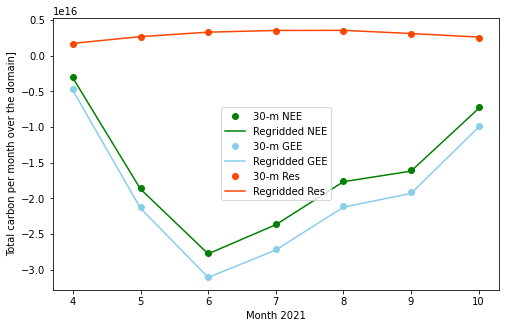

In [16]:
fig,ax=plt.subplots(1, figsize=(8, 5))
ax.plot(range(4, 11), sml_per_mon, label='30-m NEE', color='green', linestyle='', marker='o')
ax.plot(range(4, 11), lrg_per_mon, label='Regridded NEE', color='green', linestyle='-')
ax.plot(range(4, 11), sml_per_mon_gee, label='30-m GEE', color='skyblue', linestyle='', marker='o')
ax.plot(range(4, 11), lrg_per_mon_gee, label='Regridded GEE', color='skyblue', linestyle='-')
ax.plot(range(4, 11), sml_per_mon_res, label='30-m Res', color='orangered', linestyle='', marker='o')
ax.plot(range(4, 11), lrg_per_mon_res, label='Regridded Res', color='orangered', linestyle='-')
ax.legend(loc='upper center')
ax.set_xlabel('Month 2021')
ax.set_ylabel('Total carbon per month over the domain]')
ax.legend()

In [ ]:
# Time series of each land type
NLCD_def = {"OTH":11, "SNW":12, \
            "DEO":21, "DEL":22, "DEM":23, "DEH":24,"BRL":31,\
            "DBF":41, "EVF":42, "MXF":43, "SHB":52,\
            "GRS":71, "PST":81, "CRP":82, "WDW":90, "EHW":95}
DBF_ave = np.array([np.nanmean(NEE_all[x, NLCD_2D==41]) for x in range(0, len(Time_all))])
GRS_ave = np.array([np.nanmean(NEE_all[x, NLCD_2D==71]) for x in range(0, len(Time_all))])
DEO_ave = np.array([np.nanmean(NEE_all[x, NLCD_2D==21]) for x in range(0, len(Time_all))])
DEL_ave = np.array([np.nanmean(NEE_all[x, NLCD_2D==22]) for x in range(0, len(Time_all))])
DEM_ave = np.array([np.nanmean(NEE_all[x, NLCD_2D==23]) for x in range(0, len(Time_all))])
DEH_ave = np.array([np.nanmean(NEE_all[x, NLCD_2D==24]) for x in range(0, len(Time_all))])

fig = plt.figure(figsize=(23,23))
FontSize = 10
LineWidth =4
col = 1

# DBF
land_ave = [DBF_ave, GRS_ave, DEO_ave, DEL_ave, DEM_ave, DEH_ave]
row = len(land_ave)
Title_txt = ['DBF', 'GRS', 'DEO', 'DEL', 'DEM', 'DEH']
for x in range(1, row+1):
    ax = fig.add_subplot(row, col, x)
    ax.set_title(Title_txt[x-1])
    ax.plot(Time_all, land_ave[x-1], color='skyblue', linewidth=LineWidth)
    ax.set_ylim(-45, 10)
    ax.set_ylabel('NEE', fontsize = FontSize)
    ax.grid()


In [ ]:
print(l)

In [2]:
2411760*0.030*.030

2170.584